# Spectrum fitting tools
# スペクトルフィッティングツール
車輪の再発明的にフィッティングを一から作って、最終的にはスペクトルを分離フィッティングする。

## 参考にしたサイト
[Pythonで非線形関数モデリング](https://qiita.com/hik0107/items/9bdc236600635a0e61e8)  
[研究者のための実践データ処理～Pythonでピークフィッティング～](https://qiita.com/kon2/items/6498e66af55949b41a99)

In [1]:
# import files
from numpy import exp, arange, where,inf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## ガウス関数
スペクトルのピークはガウス関数で近似できいると仮定する  
ガウス関数は  
$$
y = a\exp \biggl\{ -\frac{(x-b)^{2}}{2c^{2}} \biggr\}
$$
で表される。

In [2]:
def gaussian(x,a=1,b=0,c=1):
    """
    ガウス関数を返す
    Parameters
    ----------
    x : numpy.ndarray
    a : float
    b : float
    c : float
    Returns
    -------
    gaussian : numpy.ndarray
    """
    return a*exp(-(x-b)**2/(2*c**2))

## 単一のガウス関数フィッティング
### 初期値の設定  

- a: データ列の最大値  
- b: 最大値を与える位置
- c: 半値幅　　

を設定して計算させる
### 解析範囲の設定
Gauss関数の場合、半値幅（FWHM)は
$$
FWHM = 2\sqrt{2\ln{2}}\sigma \approx 2.35\sigma
$$
なので、FWHMを解析範囲に設定

In [3]:
def peak_info(data):
    """
    データの最大値の高さ、位置、半値幅を返す
    Parameters
    ----------
    data : numpy.ndarray
        入力データ
    Returns
    -------
    height : float
        データの最大値
    pos : int
        最大値を与えるインデックス
    width : int
        半値幅
    """
   
    def find_first_index(x,flag):
        """
        Boolean列でFlag値が最初に現れる位置を返す
        Parameters
        ----------
        x : list
            True/False
        flag : bool 
           True or False
        Returns
        -------
        find_first_index : int
            最初にflagとなったインデックス
        """
        for i in range(len(x)):
            if x[i]  == flag:
                break
        return i
    height = data.max()
    pos = data.argmax()
    low = find_first_index(data[pos:0:-1] < height/2,True)
    high = find_first_index(data[pos::] < height/2,True)
    width = low+high
    return height, pos, width

In [4]:
def fit_gaussian(data):
    """
    最大値付近をガウス関数でフィッティングする
    Parameters
    ----------
    data : numpy.ndarray
        入力データ
    Returns
    -------
    param : numpy.ndarray
        フィッティングしたピーク高さ
        フィッティングしたピーク位置
        フィッティングしたピークの半値幅
    """   
    p0 = peak_info(data)
    xs = arange(len(data)) # X列を生成
    bounds =((0,p0[1]-p0[2]/2,0),(inf,p0[1]+p0[2]/2,inf)) # 解析範囲を限定
    param ,_ =  curve_fit(gaussian, xs, data, p0=p0,bounds=bounds)
    return param

## ガウス関数をプロットする

In [8]:
def plot_gaussians(xs, params):
    """
    ガウス関数をプロットする
    Parameters
    ----------
    xs : numpy.ndarray
    params : numpy.ndarray
        ガウスパラメータのリスト
    """
    for param in params:
        plt.plot(xs, gaussian(xs,a = param[0], b = param[1], c = param[2]))

In [6]:
# TEST Code
xs = arange(100)
ys = gaussian(xs,a=1,b=15,c=5)
param = fit_gaussian(ys)

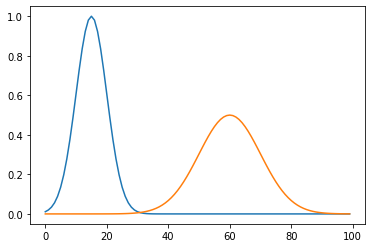

In [11]:
plot_gaussians(xs,[param,[0.5,60,10]])